# Refitting PyMC models with ArviZ

ArviZ is backend agnostic and therefore does not sample directly. In order to take advantage of algorithms that require refitting models several times, ArviZ uses {class}`~arviz.SamplingWrapper` to convert the API of the sampling backend to a common set of functions. Hence, functions like Leave Future Out Cross Validation can be used in ArviZ independently of the sampling backend used.

Below there is an example of `SamplingWrapper` usage for [PyMC](https://www.pymc.io/projects/docs/en/stable/learn.html).

In [1]:
import arviz as az
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

For the example we will use a linear regression model.

In [2]:
rng = np.random.default_rng(4)

xdata = np.linspace(0, 50, 100)
b0, b1, sigma = -2, 1, 3
ydata = rng.normal(loc=b1 * xdata + b0, scale=sigma)

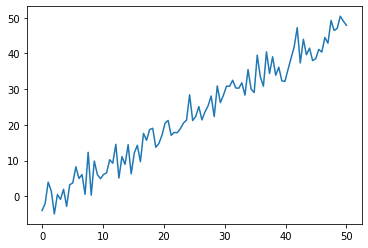

In [3]:
plt.plot(xdata, ydata);

Now we will write the PyMC3 model, keeping in mind that the data must be modifiable (both `x` and `y`).

In [4]:
with pm.Model() as linreg_model:
    # optional: add coords to "time" dimension
    linreg_model.add_coord("time", np.arange(len(xdata)), mutable=True)

    x = pm.MutableData("x", xdata, dims="time")
    y_obs = pm.MutableData("y_obs", ydata, dims="time")

    b0 = pm.Normal("b0", 0, 10)
    b1 = pm.Normal("b1", 0, 10)
    sigma_e = pm.HalfNormal("sigma_e", 10)

    pm.Normal("y", b0 + b1 * x, sigma_e, observed=y_obs, dims="time")

In [5]:
sample_kwargs = {"chains": 4, "draws": 500}
with linreg_model:
    idata = pm.sample(**sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, sigma_e]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 5 seconds.


We have defined a dictionary `sample_kwargs` that will be passed to the `SamplingWrapper` in order to make sure that all refits use the same sampler parameters. 

We will create a subclass of `az.SamplingWrapper`. 

In [6]:
from scipy import stats
from xarray_einstats.stats import XrContinuousRV


class PyMCLinRegWrapper(az.PyMCSamplingWrapper):
    def sample(self, modified_observed_data):
        with self.model:
            # if the model had coords the dim needs to be updated before
            # modifying the data in the model with set_data
            # otherwise, we don't need to overwrite the sample method
            n__i = len(modified_observed_data["x"])
            self.model.set_dim("time", n__i, coord_values=np.arange(n__i))

            pm.set_data(modified_observed_data)
            idata = pm.sample(
                **self.sample_kwargs,
            )
        return idata

    def log_likelihood__i(self, excluded_observed_data, idata__i):
        post = idata__i.posterior
        dist = XrContinuousRV(
            stats.norm,
            post["b0"] + post["b1"] * excluded_observed_data["x"],
            post["sigma_e"],
        )
        return dist.logpdf(excluded_observed_data["y_obs"])

    def sel_observations(self, idx):
        xdata = self.idata_orig["constant_data"]["x"]
        ydata = self.idata_orig["observed_data"]["y"]
        mask = np.isin(np.arange(len(xdata)), idx)
        data_dict = {"x": xdata, "y_obs": ydata}
        data__i = {key: value.values[~mask] for key, value in data_dict.items()}
        data_ex = {key: value.isel(time=idx) for key, value in data_dict.items()}
        return data__i, data_ex

In [7]:
loo_orig = az.loo(idata, pointwise=True)
loo_orig

Computed from 2000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -255.84     6.31
p_loo        2.70        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In this case, the Leave-One-Out Cross Validation (LOO-CV) approximation using [Pareto Smoothed Importance Sampling](https://arxiv.org/abs/1507.02646) (PSIS) works for all observations, so we will use modify `loo_orig` in order to make `az.reloo` believe that PSIS failed for some observations. This will also serve as a validation of our wrapper, as the PSIS LOO-CV already returned the correct value.

In [8]:
loo_orig.pareto_k[[13, 42, 56, 73]] = np.array([0.8, 1.2, 2.6, 0.9])

We initialize our sampling wrapper

In [9]:
pymc_wrapper = PyMCLinRegWrapper(model=linreg_model, idata_orig=idata, sample_kwargs=sample_kwargs)

And eventually, we can use this wrapper to call `az.reloo`, and compare the results with the PSIS LOO-CV results.

In [10]:
loo_relooed = az.reloo(pymc_wrapper, loo_orig=loo_orig)

/home/oriol/Public/arviz/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, sigma_e]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, sigma_e]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, sigma_e]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, sigma_e]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 4 seconds.


In [11]:
loo_relooed

Computed from 2000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -255.82     6.30
p_loo        2.69        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [12]:
loo_orig

Computed from 2000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -255.84     6.31
p_loo        2.70        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       96   96.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         2    2.0%
   (1, Inf)   (very bad)    2    2.0%